Primeiro conseguir separar a imagem por regiao onde identifica a prova e onde marca as questoes

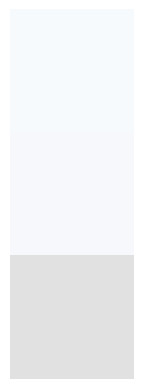

In [7]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Carregue a imagem
# image = cv2.imread('.\Leitor\provas_realizadas\scan0000.jpg')
# image_resize = cv2.resize(image, None, fx=0.5, fy=0.5)
# image_copy = cv2.resize(image, None, fx=0.5, fy=0.5)

# # Converta a imagem para tons de cinza
# gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray,(1,1),1000)
# _, thresh = cv2.threshold(blur, 195, 255, cv2.THRESH_BINARY)

# # Detecte os contornos na imagem
# contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours = sorted(contours, key=cv2.contourArea, reverse=True) 

# warped_images = []

# for contorno in contours:
#     # Obtém o retângulo delimitador do contorno
#     (x, y, w, h) = cv2.boundingRect(contorno)
    
#     # Verifica se a área é grande o suficiente (evita contornos pequenos indesejados)
#     if cv2.contourArea(contorno) > 1000:
#         # Obtém os pontos dos cantos do retângulo delimitador
#         pts1 = np.float32([[x, y], [x+w, y], [x+w, y+h], [x, y+h]])
        
#         # Define os pontos para onde a região deve ser transformada
#         pts2 = np.float32([[0, 0], [399, 0], [399, 399], [0, 399]])
        
#         # Calcula a matriz de transformação
#         M = cv2.getPerspectiveTransform(pts1, pts2)
        
#         # Aplica a transformação à região de interesse (ROI)
#         warped = cv2.warpPerspective(image_resize, M, (400, 400))
#         warped_images.append(warped)

# # Exibe as imagens transformadas
# for i, warped in enumerate(warped_images):
#     plt.plot(1, len(warped_images), i+1)
#     plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
#     plt.axis('off')

# plt.show()

# # Exibe outras imagens (se houver)
# cv2.imshow('image_resize', image_resize)
# cv2.imshow('binary_frame', thresh)
# cv2.imshow('image_copy', image_copy)

# cv2.waitKey(0)
# cv2.destroyAllWindows()


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Diretório da pasta que contém as imagens
# diretorio_pasta = '.\Leitor\provas_realizadas'

# # Lista de arquivos na pasta
# arquivos_na_pasta = os.listdir(diretorio_pasta)
# index = 0

# for arquivo in arquivos_na_pasta:
#     if arquivo.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
#         caminho_arquivo = os.path.join(diretorio_pasta, arquivo)

image = cv2.imread('.\Leitor\provas_realizadas\scan0002.jpg')
image_resize = cv2.resize(image, None, fx=0.5, fy=0.5)
image_copy = cv2.resize(image, None, fx=0.5, fy=0.5)

# Converta a imagem para tons de cinza
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(1,1),1000)
_, thresh = cv2.threshold(blur, 195, 255, cv2.THRESH_BINARY)

# Detecte os contornos na imagem
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True) 

area_minima_desejada = 10
area_maxima_desejada = 60000

# Filtrar os contornos com área maior que o valor desejado
filtered_countourns = [cont for cont in contours if (cv2.contourArea(cont) > area_minima_desejada) and (cv2.contourArea(cont) < area_maxima_desejada)]

cv2.drawContours(thresh, filtered_countourns, -1, (0, 0, 255), 1)

nova_imagem = np.zeros_like(thresh)

# Desenhe os contornos filtrados na nova imagem
cv2.drawContours(nova_imagem, filtered_countourns, -1, (255, 255, 255), thickness=cv2.FILLED)

# Salve a nova imagem
cv2.imshow('nova_imagem.png', nova_imagem)

maior_contorno = max(filtered_countourns, key=cv2.contourArea)

# Encontre o ângulo de rotação com base na orientação do maior contorno
(x, y), (largura, altura), angulo = cv2.minAreaRect(maior_contorno)

# Garanta que o ângulo esteja no intervalo de -45 a 45 graus
if angulo < -45:
    angulo += 90

# Rotação da imagem para endireitar
altura, largura = nova_imagem.shape[:2]
rotacao_matriz = cv2.getRotationMatrix2D((largura / 2, altura / 2), angulo, 1)
imagem_endireitada = cv2.warpAffine(nova_imagem, rotacao_matriz, (largura, altura), flags=cv2.INTER_LINEAR)

# Mostre a imagem endireitada
cv2.imshow('Imagem Endireitada.png', imagem_endireitada)

filtro_nitidez = np.array([[-1, -1, -1],
                        [-1,  9, -1],
                        [-1, -1, -1]])
imagem_nitidez = cv2.filter2D(imagem_endireitada, -1, filtro_nitidez)

_, imagem_binaria = cv2.threshold(imagem_nitidez, 128, 255, cv2.THRESH_BINARY)

contornos, _ = cv2.findContours(imagem_nitidez, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Lista para armazenar os retângulos que atendem aos critérios
retangulos_desejados = []

# Encontre e desenhe as áreas retangulares que atendem aos critérios
for contorno in contornos:
    x, y, largura, altura = cv2.boundingRect(contorno)
    
    if largura >= 30 * altura:
        # Adicione as coordenadas do retângulo desejado à lista
        retangulos_desejados.append((x, y, largura, altura))

# Recorte as áreas dos retângulos desejados da imagem original
areas_recortadas = []
for x, y, largura, altura in retangulos_desejados:
    area_recortada = imagem_nitidez[y:y+altura, x:x+largura]
    areas_recortadas.append(area_recortada)

altura, largura = area_recortada.shape[:2]
comprimento_parte = largura // 5

prova = 0
partes_imagem = []
for i in range(5):
    parte = area_recortada[:, i * comprimento_parte: (i + 1) * comprimento_parte]
    partes_imagem.append(parte)

# Detecte círculos em cada parte da imagem
for i, parte in enumerate(partes_imagem):
    altura1, largura1 = parte.shape
    regiao_interesse = None
# Defina a largura da região de interesse como os primeiros 25% da imagem
    match i:
        case 0:
            print('entrou 1')
            largura_regiao_interesse = int(largura1 * 0.20)
            regiao_interesse = parte[:, :largura_regiao_interesse]
        case 1:
            print('entrou 2')
            largura_regiao_interesse = int(largura1 * 0.30)
            regiao_interesse = parte[:, :largura_regiao_interesse]
        case 2:
            print('entrou 3')
            largura_regiao_interesse = int(largura1 * 0.40)
            regiao_interesse = parte[:, :largura_regiao_interesse]
        case 3:
            print('entrou 4')
            largura_regiao_interesse = int(largura1 * 0.45)
            regiao_interesse = parte[:, :largura_regiao_interesse]
        case 4:
            print('entrou 5')
            largura_regiao_interesse = int(largura1 * 0.60)
            regiao_interesse = parte[:, :largura_regiao_interesse]
    # Selecione a região de interesse na imagem
    cv2.imshow(f'Região de Interesse {i}', regiao_interesse)

    circulos = cv2.HoughCircles(
        regiao_interesse,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=12,  # Distância mínima entre os centros dos círculos
        param1=4,   # Limiar para detecção de bordas
        param2=4,   # Limiar para detecção de círculos
        minRadius=3,  # Raio mínimo do círculo
        maxRadius=8   # Raio máximo do círculo
    )

    if circulos is not None:
        circulos = np.uint16(np.around(circulos))

        # Itere pelos círculos detectados
        for circulo in circulos[0, :]:
            centro_x, centro_y, raio = circulo
            intensidade_cor_centro = None

            if centro_x >= raio and centro_x < regiao_interesse.shape[1] - raio and centro_y >= raio and centro_y < regiao_interesse.shape[0] - raio:
                intensidade_cor_centro = regiao_interesse[centro_y, centro_x]
                cv2.circle(regiao_interesse, (centro_x, centro_y), 2, -1)
                cv2.imshow(f'{i}', regiao_interesse)
            if(intensidade_cor_centro != None):
                print(intensidade_cor_centro)
                #Determine se a intensidade de cor no centro do círculo é próxima ao branco (intensidade alta)
                if intensidade_cor_centro > 250:
                    prova = i + 1
                    break
# print(f'{index}° prova')
print(prova)
# Exemplo de classificação final
if prova == 1:
    print('A imagem é classificada como A')
elif prova == 2:
    print('A imagem é classificada como B')
elif prova == 3:
    print('A imagem é classificada como C')
elif prova == 4:
    print('A imagem é classificada como D')
elif prova == 5:
    print('A imagem é classificada como E')

# Exiba a imagem com as áreas retangulares desenhadas (opcional)
cv2.imshow('Imagem com Áreas Retangulares', imagem_nitidez)

for contorno in contours:
    (x, y, w, h) = cv2.boundingRect(contorno)
    roi = image_resize[y:y+h, x:x+w]
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(roi_rgb)
    # so ta printando 1 contorno?
    
# index += 1
# cv2.imshow('image_resize', image_resize)
# cv2.imshow('binary_frame', thresh)
# cv2.imshow('image_copy', thresh)


cv2.waitKey(0)
cv2.destroyAllWindows()